In [17]:
# No module named 'scikeras' hatası alırsan aşağıdaki yorum satırını normal kod haline getirip kod hücresini çalıştır
!pip install scikeras



BAHAR SEVİNTİ - 22040301173

DERİN ÖĞRENME İLE GÖĞÜS KANSERİ TESPİTİ

Veri Seti: https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset

## Kütüphanelerin İmport Edilmesi


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectKBest, f_classif

## Veri Yükleme ve İnceleme

In [19]:
# Veri yükleme
data = pd.read_csv("breast-cancer.csv")

# Veri seti boyutu ve bilgisi
print("Veri seti boyutu:", data.shape)
print("\nVeri seti bilgisi:")
print(data.info())

print("\nİstatistiksel özet:")
print(data.describe())

Veri seti boyutu: (569, 32)

Veri seti bilgisi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non

## Veri Ön İşleme

In [20]:
# Aykırı değerleri tespit etme
def detect_outliers(df, features):
    outlier_indices = []

    for column in features:
        # Sayısal sütunları kontrol et
        if df[column].dtype in ['int64', 'float64']:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            outlier_step = IQR * 1.5

            outliers = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step)]
            outlier_indices.extend(outliers.index)

    outlier_indices = Counter(outlier_indices)
    multiple_outliers = [k for k, v in outlier_indices.items() if v > 2]

    return multiple_outliers

# Aykırı değerleri tespit et
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
outliers = detect_outliers(data, numeric_columns)
print(f"\nAykırı değer sayısı: {len(outliers)}")

# ID sütununu kaldırma
if 'id' in data.columns:
    data.drop('id', axis=1, inplace=True)

# Eksik değerleri kontrol etme
print("\nEksik Değerler:")
print(data.isnull().sum())

# Kategorik değişkeni (diagnosis) sayısala çevirme
label_encoder = LabelEncoder()
data['diagnosis'] = label_encoder.fit_transform(data['diagnosis'])


Aykırı değer sayısı: 88

Eksik Değerler:
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


## Aykırı Değer Analizi


Aykırı değer sayısı: 83


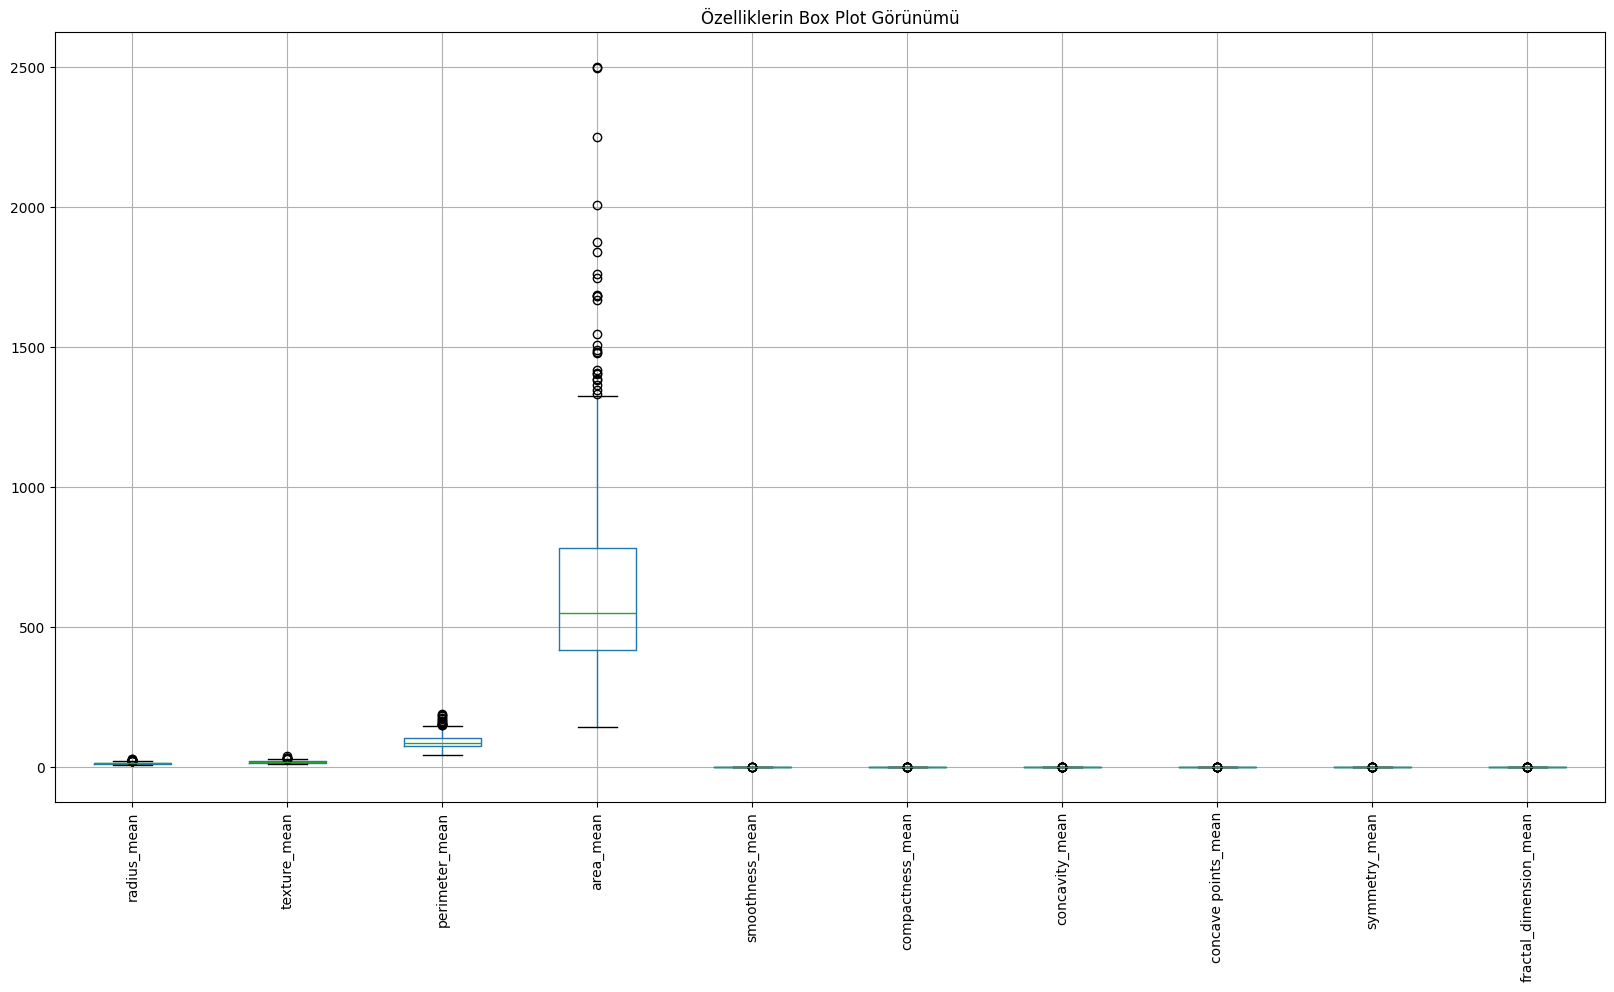

In [21]:
features_mean = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
                'smoothness_mean', 'compactness_mean', 'concavity_mean',
                'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']

def detect_outliers(df, features):
    outlier_indices = []

    for column in features:
        # Sayısal sütunları kontrol et
        if df[column].dtype in ['int64', 'float64']:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            outlier_step = IQR * 1.5

            outliers = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step)]
            outlier_indices.extend(outliers.index)

    outlier_indices = Counter(outlier_indices)
    multiple_outliers = [k for k, v in outlier_indices.items() if v > 2]

    return multiple_outliers

numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
outliers = detect_outliers(data, numeric_columns)
print(f"\nAykırı değer sayısı: {len(outliers)}")

"""Aykırı Değerlerin Görselleştirilmesi"""

# Box plot ile aykırı değerleri görselleştirme
plt.figure(figsize=(20, 10))
data[features_mean].boxplot()
plt.xticks(rotation=90)
plt.title('Özelliklerin Box Plot Görünümü')
plt.show()

##Keşifsel Veri Analizi (EDA)

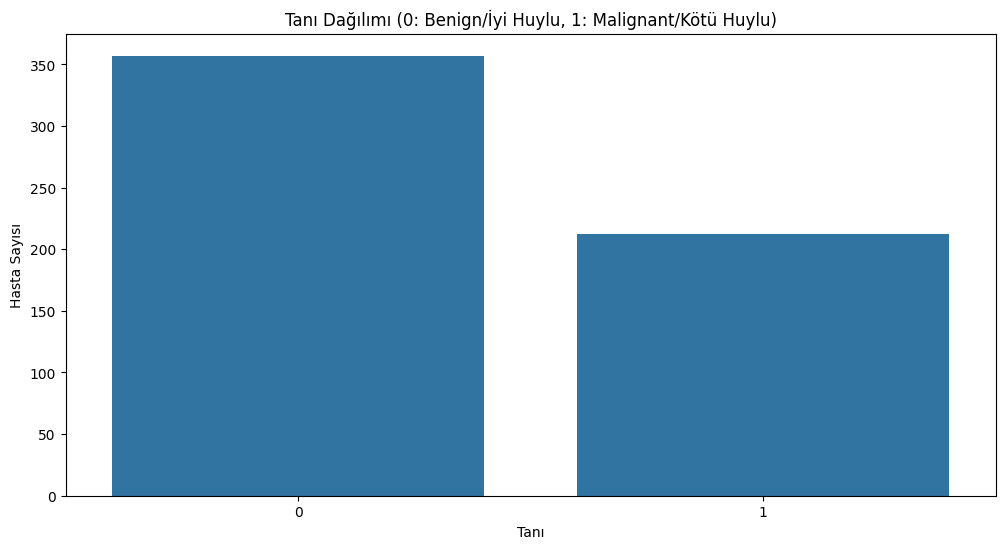

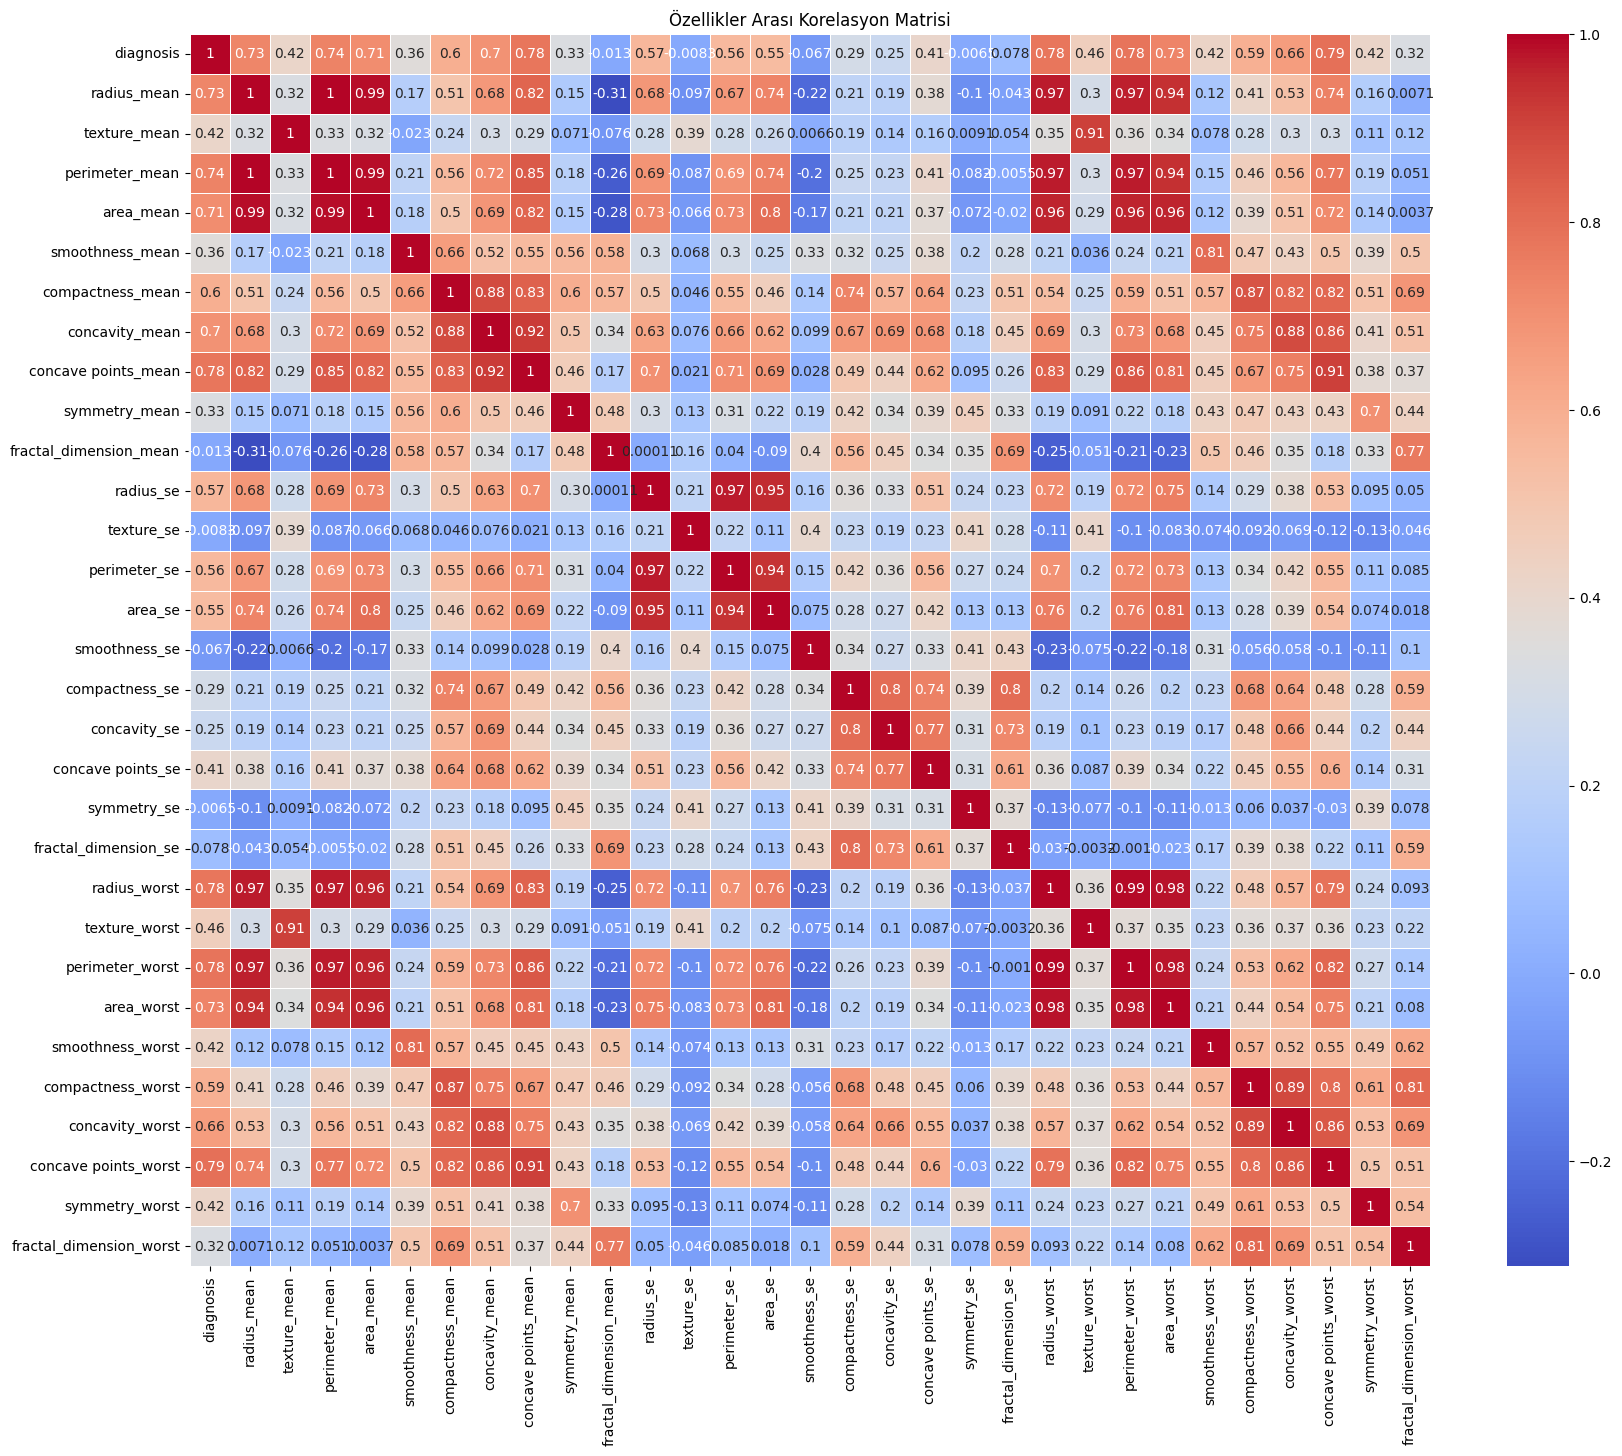

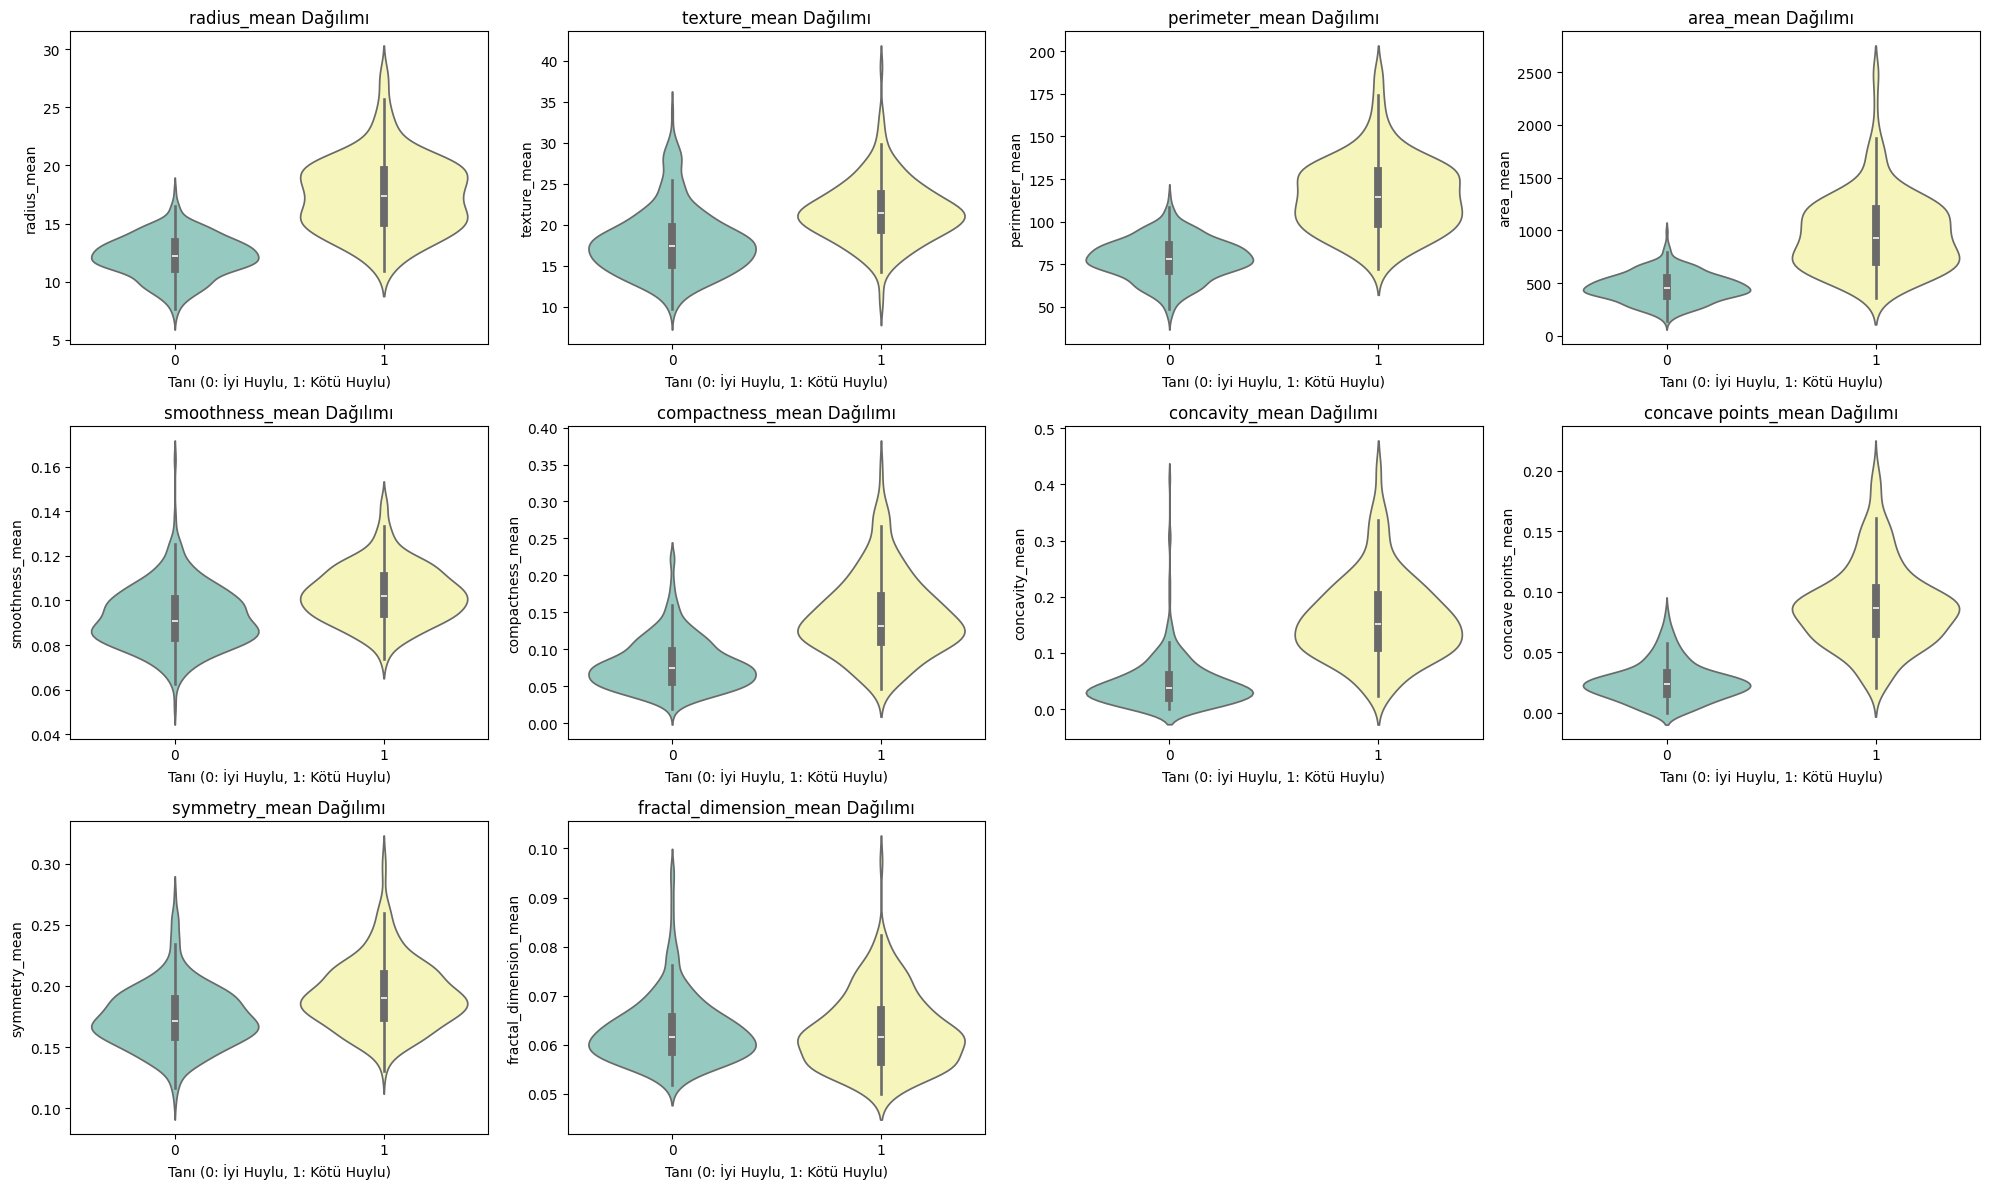

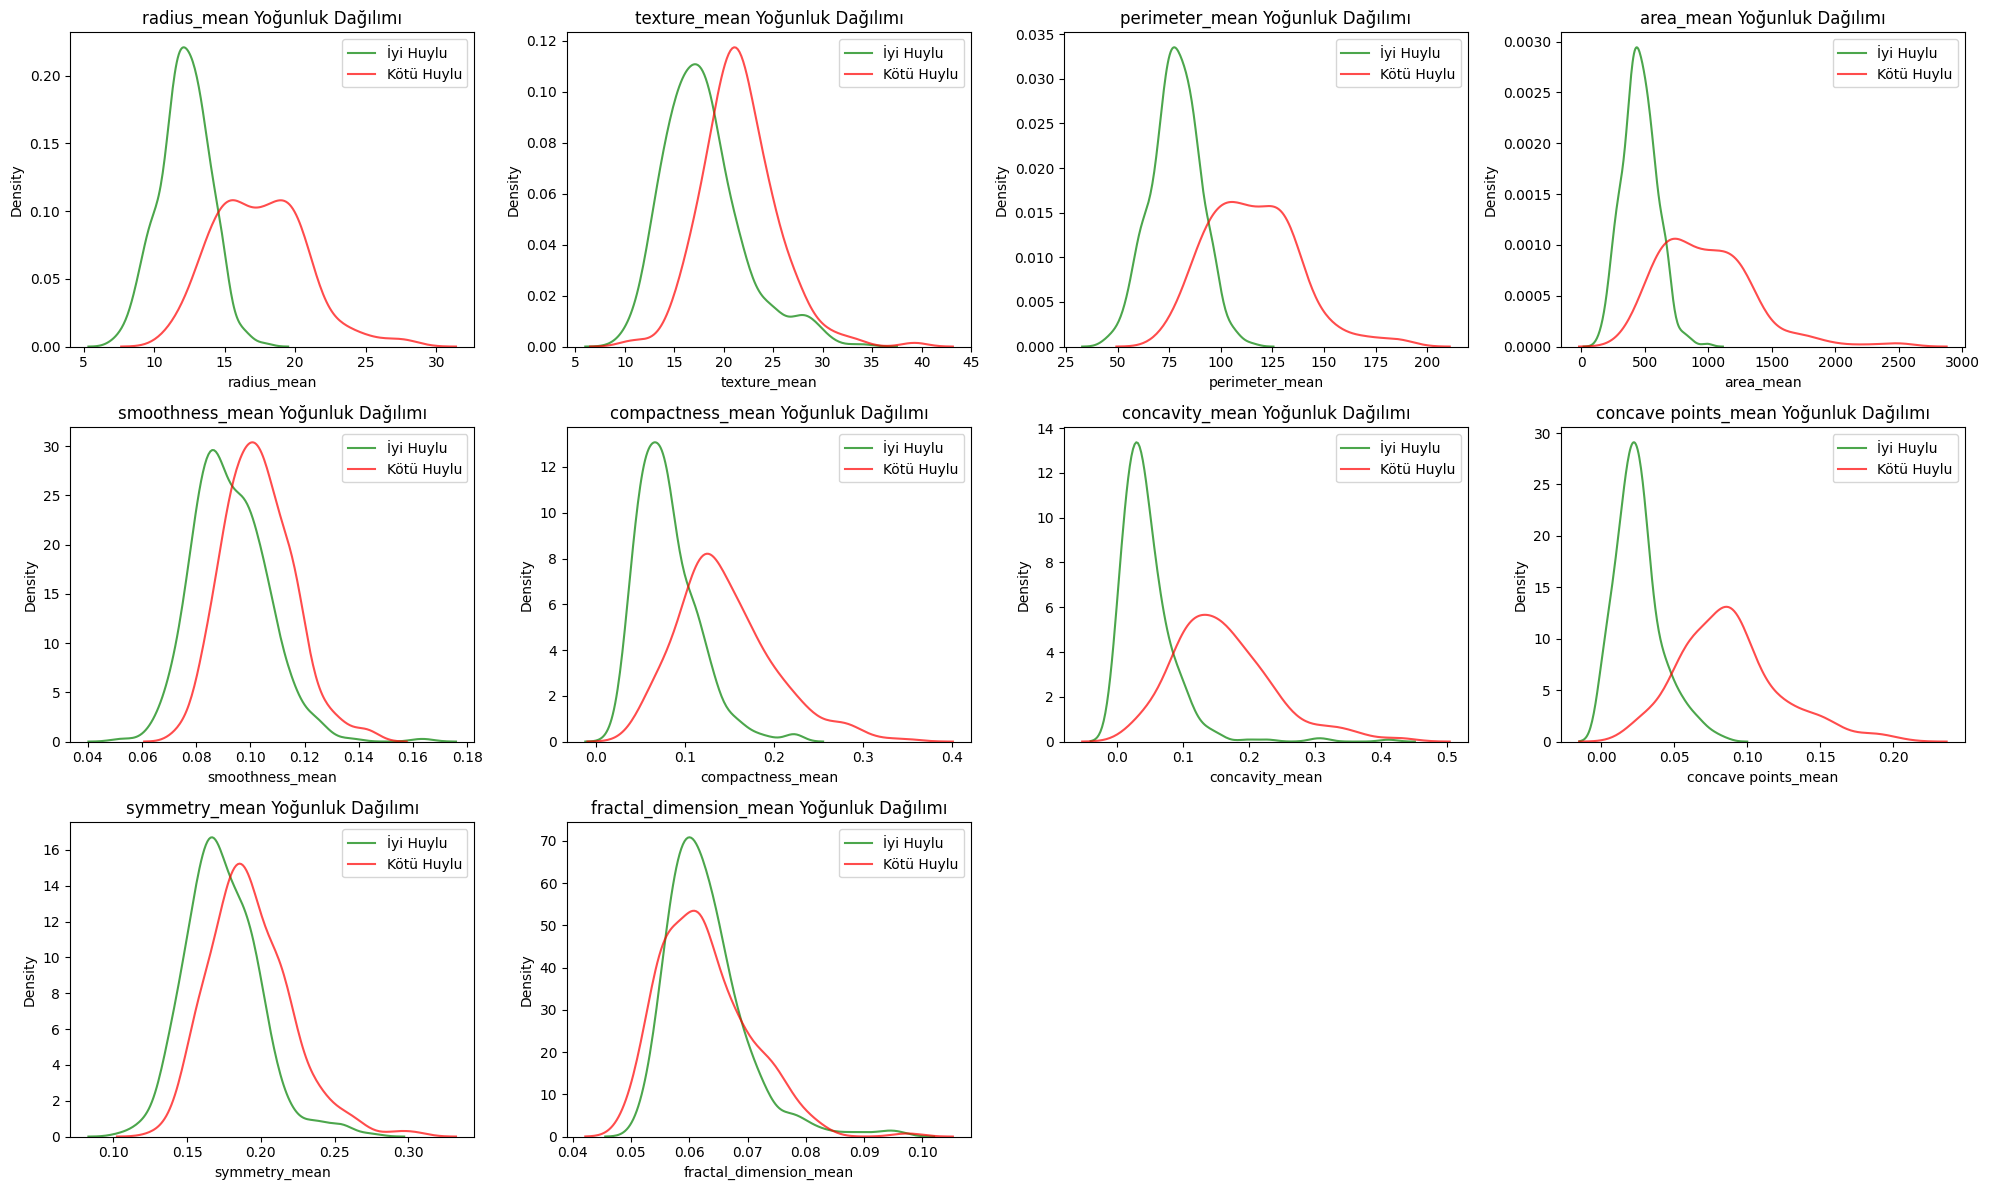

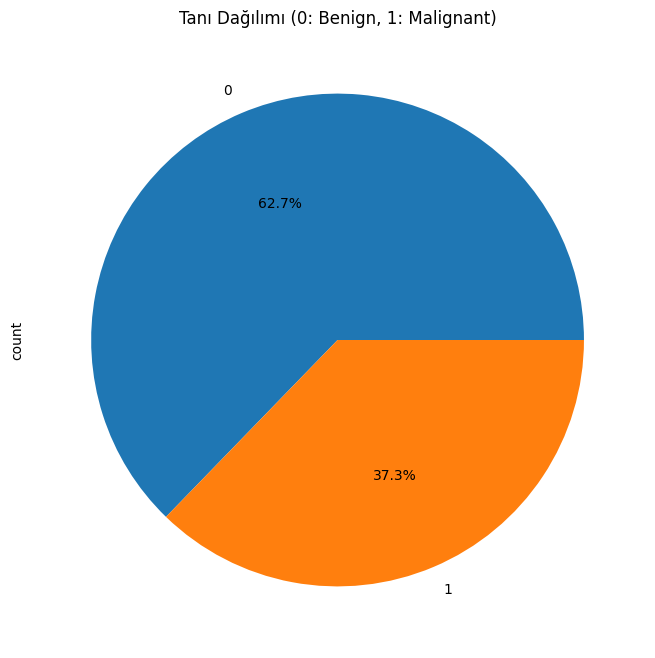

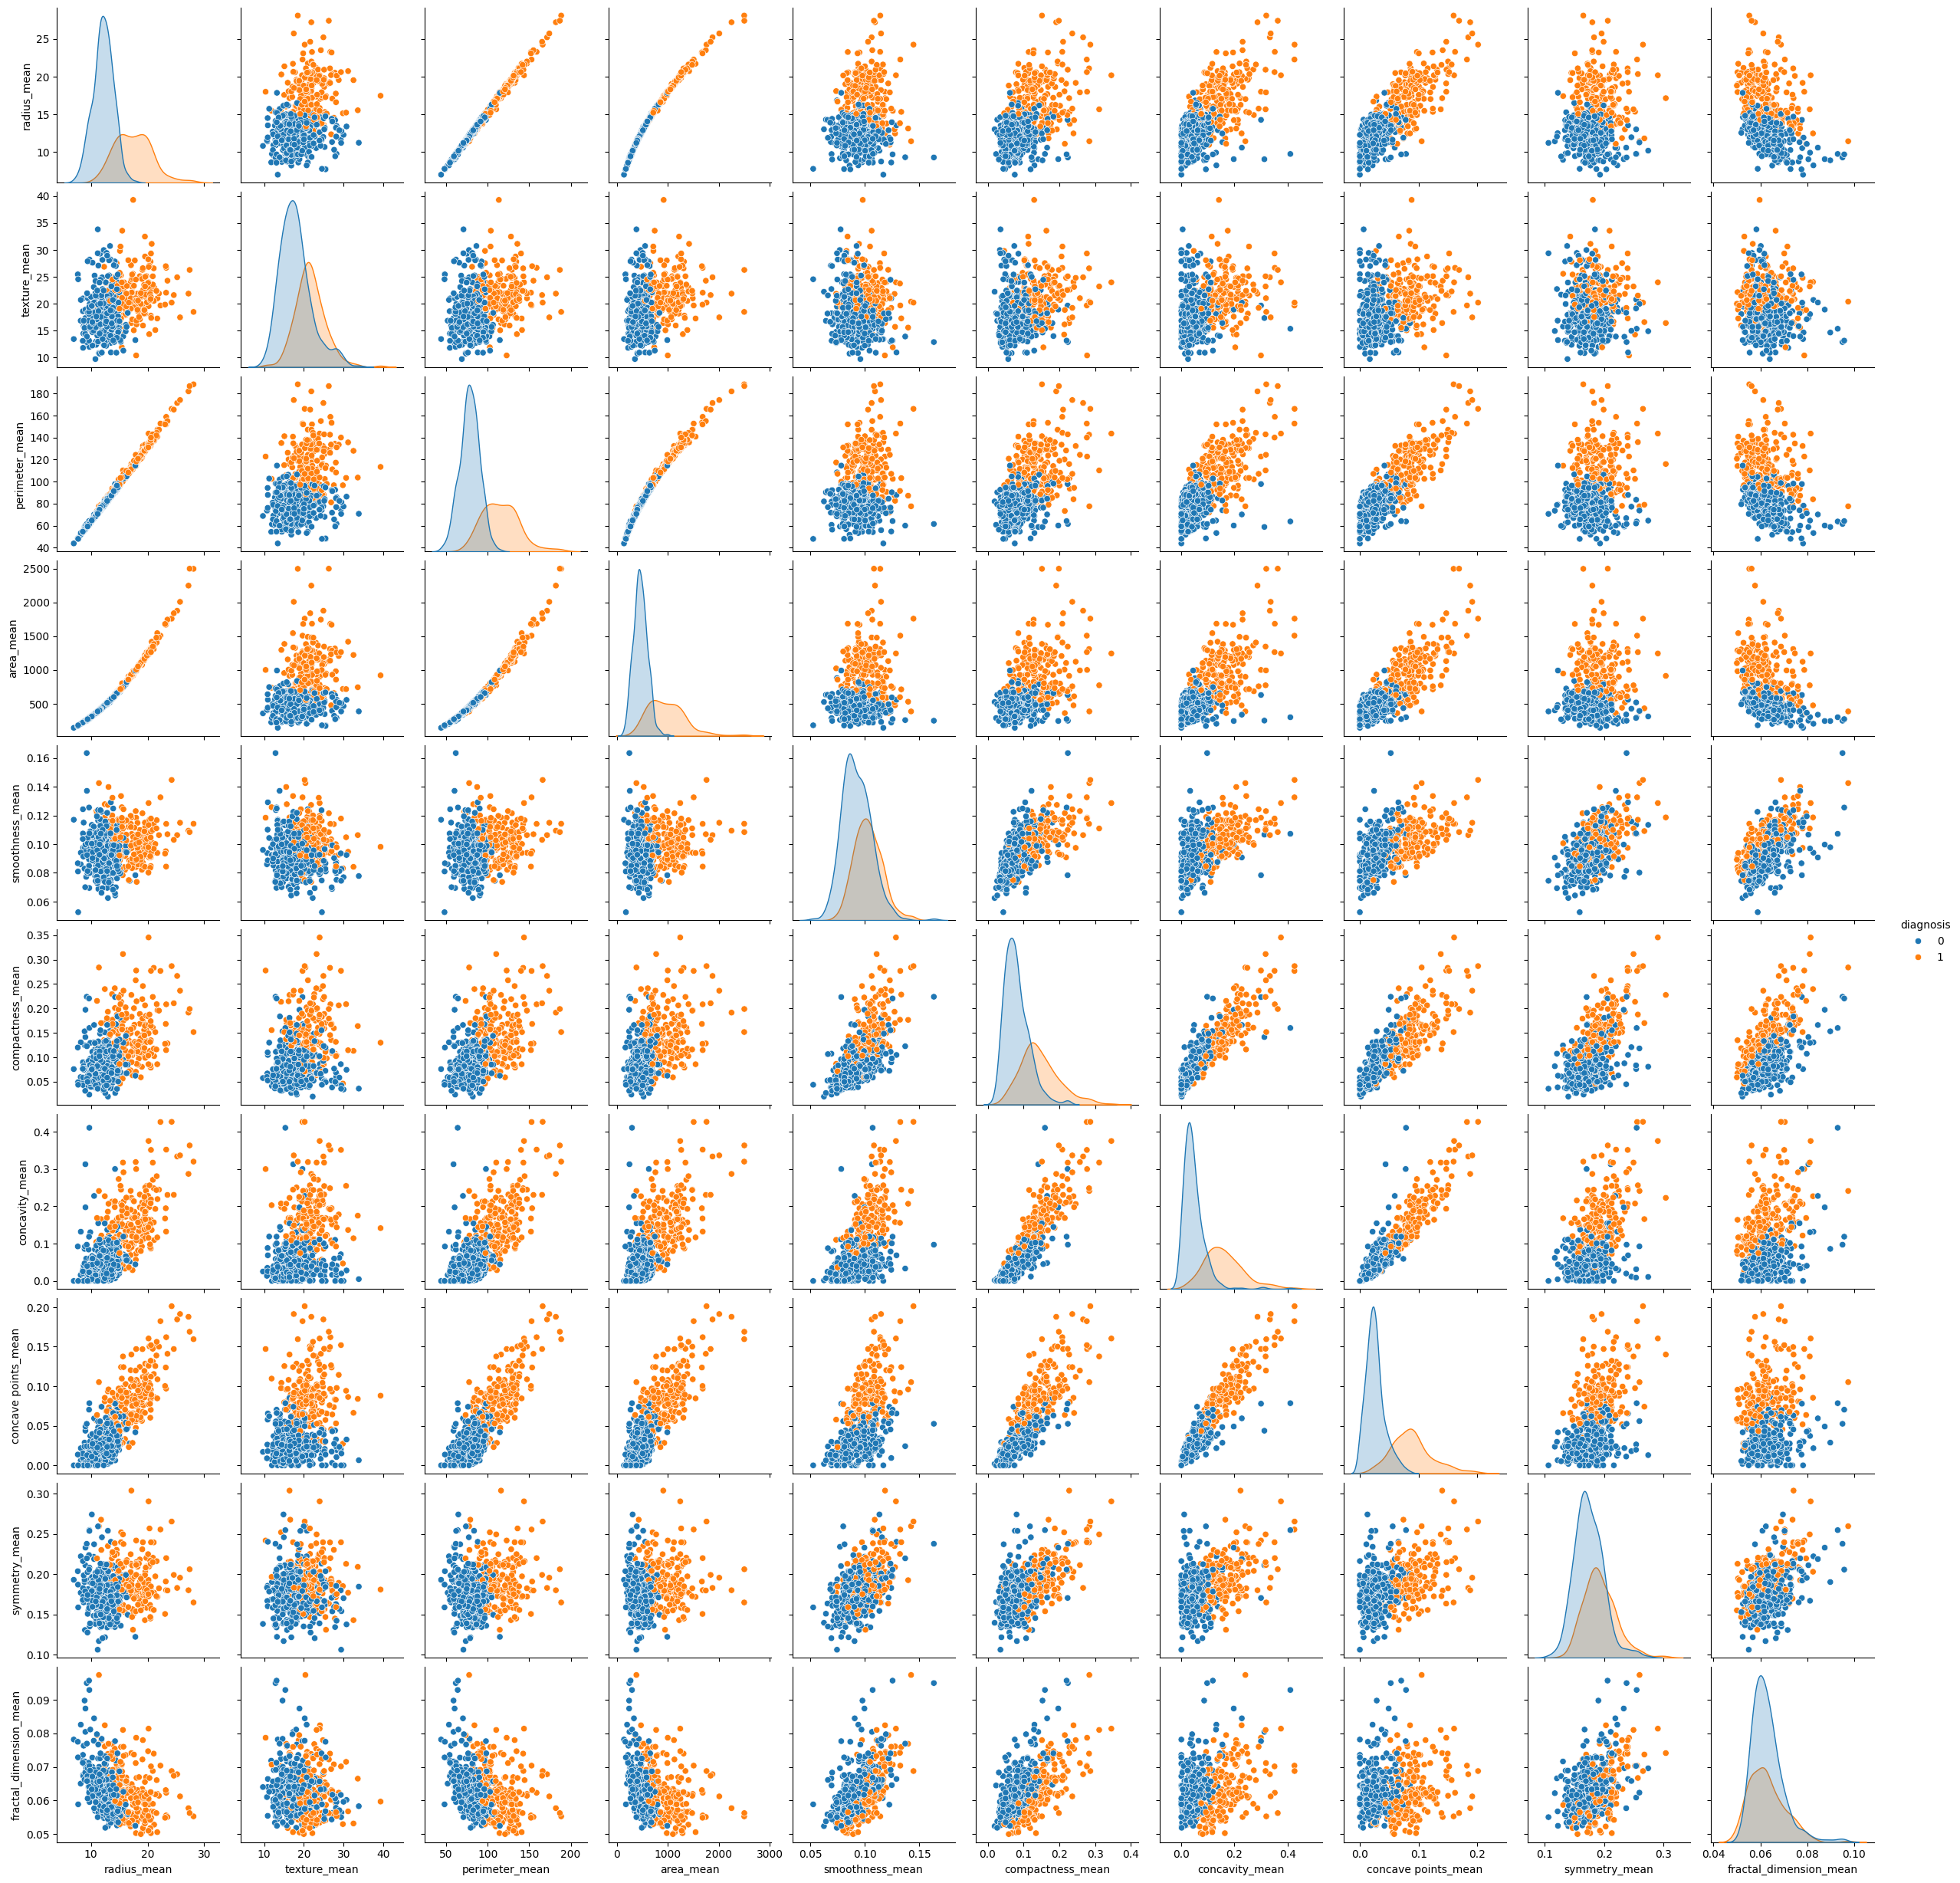

In [22]:
# Tanı Dağılımı
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='diagnosis')
plt.title('Tanı Dağılımı (0: Benign/İyi Huylu, 1: Malignant/Kötü Huylu)')
plt.xlabel('Tanı')
plt.ylabel('Hasta Sayısı')
plt.show()

# Korelasyon Matrisi
plt.figure(figsize=(20, 16))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Özellikler Arası Korelasyon Matrisi')
plt.show()

# Önemli özelliklerin dağılımları - Violin Plots Grafiiği
features_mean = list(data.columns[1:11])
plt.figure(figsize=(20, 12))
for i, feature in enumerate(features_mean, 1):
    plt.subplot(3, 4, i)
    sns.violinplot(x='diagnosis', y=feature, data=data, palette='Set3')
    plt.title(f'{feature} Dağılımı')
    plt.xlabel('Tanı (0: İyi Huylu, 1: Kötü Huylu)')
plt.tight_layout()
plt.show()

# KDE Plot ile sınıflar arassı dağılım karşılaştırması
plt.figure(figsize=(20, 12))
for i, feature in enumerate(features_mean, 1):
    plt.subplot(3, 4, i)
    sns.kdeplot(data=data[data['diagnosis']==0][feature],
                label='İyi Huylu', color='green', alpha=0.7)
    sns.kdeplot(data=data[data['diagnosis']==1][feature],
                label='Kötü Huylu', color='red', alpha=0.7)
    plt.title(f'{feature} Yoğunluk Dağılımı')
    plt.legend()
plt.tight_layout()
plt.show()

# Sınıf dağılımı pasta grafiği
plt.figure(figsize=(8, 8))
data['diagnosis'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Tanı Dağılımı (0: Benign, 1: Malignant)')  # İyi Huylu, Kötü Huylu
plt.show()

# Özellikler arası ilişkileri gösteren pairplot
sns.pairplot(data[features_mean + ['diagnosis']], hue='diagnosis', diag_kind='kde')
plt.show()

## Model Oluşturma

In [23]:
# Model 1: Basit MLP (Multilayer Perceptron)
def create_mlp_model():
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_deep_mlp_model():
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

# Model 3: Geniş MLP
def create_wide_mlp_model():
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.02), input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l2(0.02)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.02)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    return model

# Model 4: Residual Bağlantılı MLP
def create_residual_mlp_model():
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.02))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Residual bağlantı
    residual = x
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.02))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = tf.keras.layers.Add()([x, residual])

    x = Dense(32, activation='relu', kernel_regularizer=l2(0.02))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

## Veri Hazırlama ve Model Eğitimi

In [24]:
# 1. Veri Hazırlama
# Label Encoding için
le = LabelEncoder()
y = le.fit_transform(data['diagnosis'])
X = data.drop('diagnosis', axis=1)  # Sadece diagnosis kolonunu çıkar

# 2. Veri Dengesizliğini Kontrol Et
class_counts = pd.Series(y).value_counts()
print("Sınıf Dağılımı:\n", class_counts)

# 3. Özellik Seçimi
selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(X, y)

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# 5. Model Tanımlaması
def create_optimized_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_selected.shape[1],),
              kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 6. Class Weights Hesaplama
class_weights = compute_class_weight('balanced',
                                   classes=np.unique(y),
                                   y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))

# 7. Model Eğitimi
model = create_optimized_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Sınıf Dağılımı:
 0    357
1    212
Name: count, dtype: int64
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7504 - loss: 1.1828 - val_accuracy: 0.3626 - val_loss: 5.2694
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8536 - loss: 0.9619 - val_accuracy: 0.3626 - val_loss: 3.6103
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8772 - loss: 0.8388 - val_accuracy: 0.3626 - val_loss: 2.7577
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8840 - loss: 0.8191 - val_accuracy: 0.3956 - val_loss: 2.0606
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8624 - loss: 0.7829 - val_accuracy: 0.4505 - val_loss: 1.5472
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8891 - loss: 0.6724 - val_accuracy: 0.5275 - val_loss: 1.1776
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9081 - loss: 0.6329 - val_accuracy: 0.6484 - val_loss: 0.9516
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/ste

## Model Değerlendirme

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Model Performansı:
Accuracy: 0.9649122807017544

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        71
           1       1.00      0.91      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



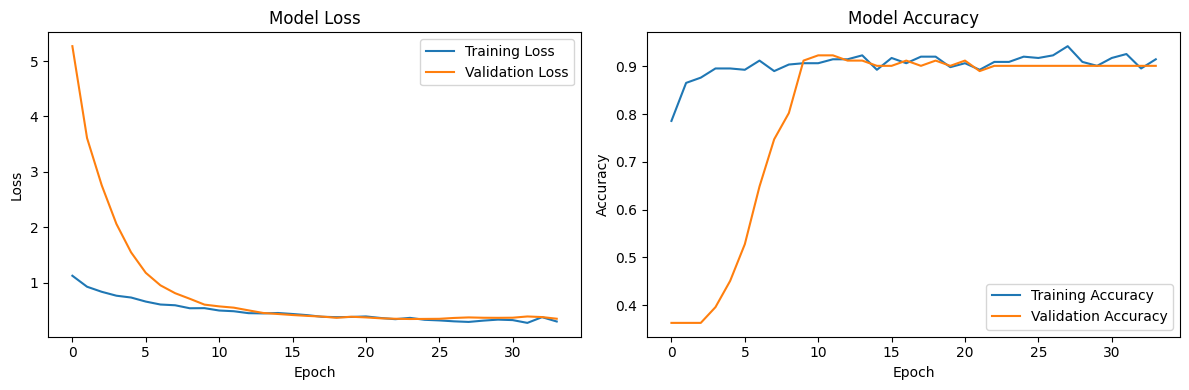

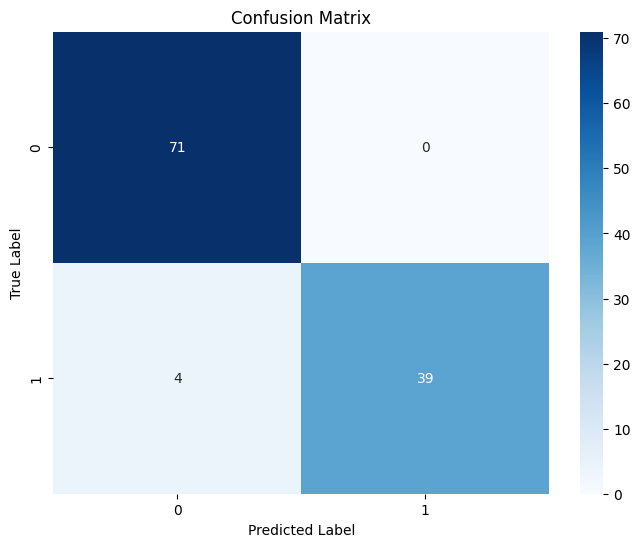


En önemli 15 özellik:
                 Feature       Score
27  concave points_worst  964.385393
22       perimeter_worst  897.944219
7    concave points_mean  861.676020
20          radius_worst  860.781707
2         perimeter_mean  697.235272
23            area_worst  661.600206
0            radius_mean  646.981021
3              area_mean  573.060747
6         concavity_mean  533.793126
26       concavity_worst  436.691939
5       compactness_mean  313.233079
25     compactness_worst  304.341063
10             radius_se  268.840327
12          perimeter_se  253.897392
13               area_se  243.651586


In [25]:
# 8. Model Değerlendirme
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("\nModel Performansı:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Model performansını görselleştirme
plt.figure(figsize=(12, 4))

# Eğitim geçmişini görselleştirme
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Önemli özellikleri görselleştirme
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
})
feature_scores = feature_scores.sort_values('Score', ascending=False)
print("\nEn önemli 15 özellik:")
print(feature_scores.head(15))